# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [28]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
#dowload data
df = pd.read_csv('/datasets/taxi.csv')
display(df.head(20))

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


### Investigate Data Types

In [3]:
#look at data types and convert if necessary
print(df.info())

#covert 'datetime' to datetime
df['datetime'] = pd.to_datetime(df['datetime'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


### Drop Duplicates

In [4]:
# drop duplicates
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates} duplicated rows in the data frame.")

There are 0 duplicated rows in the data frame.


### Fix Missing Values

In [5]:
# missing values
num_missing = df.isna().sum().sum()
print(f"There are {num_missing} missing values in the data frame.")

There are 0 missing values in the data frame.


### Resample Data

In [6]:
df.set_index('datetime', inplace=True)
df = df.resample('H').sum()
display(df.head(10))
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

## Analysis

### Plot Overall Time Series

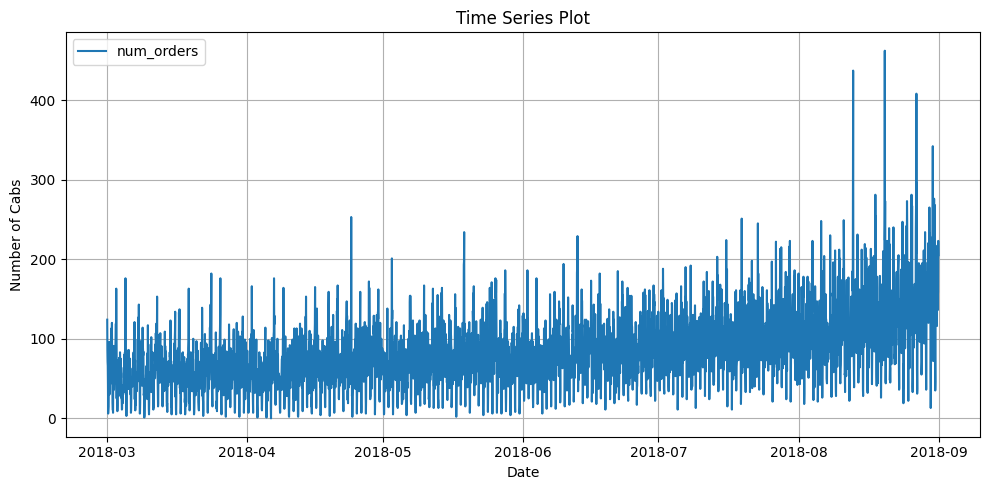

In [7]:
#plot data
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Number of Cabs')
plt.grid(True)
plt.legend(df.columns)
plt.tight_layout()
plt.show()


This time series shows the number of taxis ordered hourly from March to August of 2018. The number of taxis ordered from March through June stays relatively consistent, but does show an increase in the summer months.

### Trends, Seasonality, and Residuals

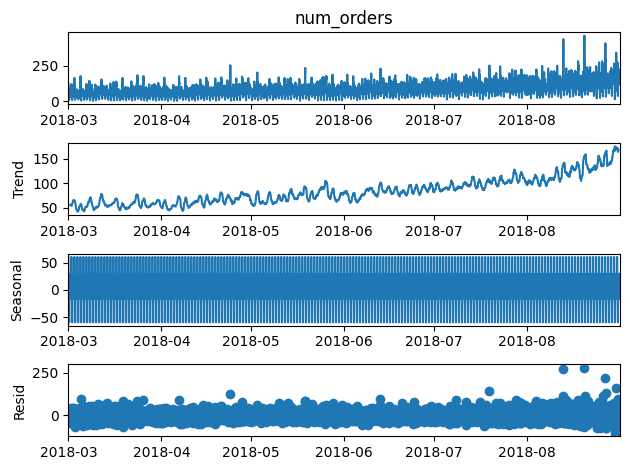

In [8]:
# look at trends, seasonality, residuals.
#whole data set
series = df['num_orders']
decomposition = seasonal_decompose(series, model='additive', period=24)
decomposition.plot()
plt.tight_layout()
plt.show()

In the seasonal decompose data, the original data is broken down into trend, seasonal, and residual data. 

The trend data shows an overall increase in the number of cab orders over time, with a steeper increase occuring after June.

Due to the high volume of hourly data, the seasonal graph is not useful to draw conclusions from. 

The residual straight line indicates that there is no pattern occuring outside of the trend and seasonality. While there are a few outliers, most of the data structure is captured in the trend and seasonality.

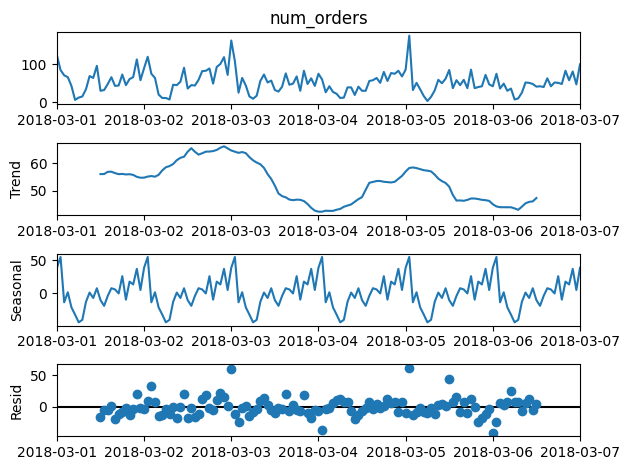

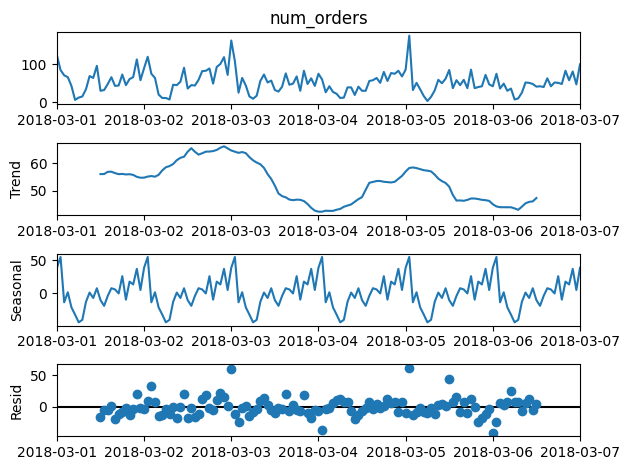

In [9]:
#subset of data to look at patterns more closely
subset = df['num_orders'].loc['2018-03-01 00:00:00	':'2018-03-07 00:00:00']

# Then decompose
result = seasonal_decompose(subset, model='additive', period=24)
result.plot()

This data shows the seasonal decmpose data for the first week of data collected. This can shed more light on the seasonal patterns of the data on a smalled scale. As seen here, it seems that the trends of the data shows increases in the number of taxis ordered at the beginning of the week with a decrease in the middle and another rise in the second half of the week. 

The seasonal data indicates spikes of data late night with a drop off in early morning and then a steady increase throughout the day. 

The residual straight line indicates that there is no pattern occuring outside of the trend and seasonality. While there are a few outliers, most of the data structure is captured in the trend and seasonality.

### Calculate Rolling Mean, Mean and Variance

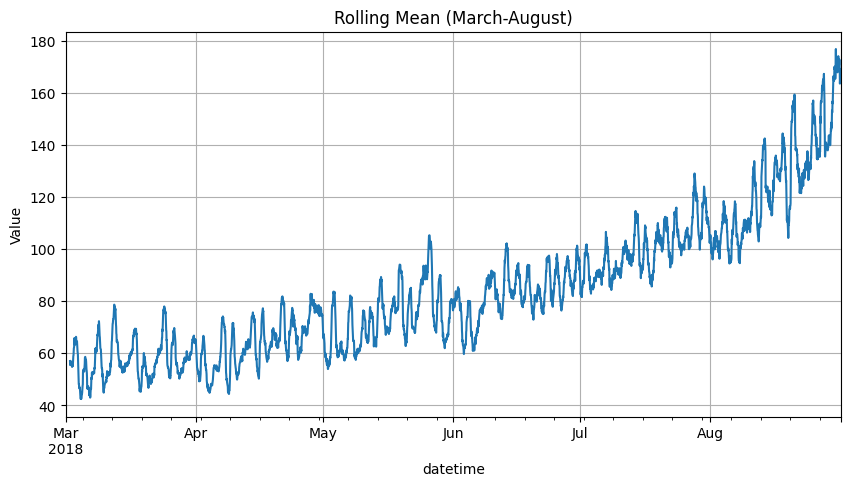

In [10]:
#calculate rolling average
df['trend_rolling'] = df['num_orders'].shift().rolling(window=24).mean()

#plot data
df['trend_rolling'].plot(figsize=(10, 5))
plt.title('Rolling Mean (March-August)')
plt.ylabel('Value')
plt.grid(True)
plt.show()


The rolling mean data shows an increase in taxis ordered over time, with a steeper increase in cabs ordered from June to August.

In [11]:
#mean/variance
mean_daily = df['num_orders'].mean()
variance_daily = df['num_orders'].var()

print(f"Hourly Mean: {mean_daily}")
print(f"Hourly Variance: {variance_daily}")

Hourly Mean: 84.42278079710145
Hourly Variance: 2027.147376727477


The data shows that on average, 14 taxis are ordered an hour. However since the variance is rather large, this indicates a high level of fluctuation in the data. This makes sense as the number of taxis varies greatly even on a daily basis. 

### Determine if Data is Stationary

In [12]:
#ADF test
result = adfuller(df['num_orders'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Optional: show critical values
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -3.0689242890279558
p-value: 0.028940051402612906
Critical Value (1%): -3.431842162413052
Critical Value (5%): -2.8621993540813637
Critical Value (10%): -2.567120978470452


The test passes at the 5% and 10% levels, but not at the 1% level. That means there's moderate to strong evidence that the series is stationary.

## Training

Two models were chosen to forecast this data:

1) AR modeling was chosen due to its suggestion of strong autocorrelation (as seen by the first few bars of the PACF)
2) SARIMA modeling was chosen as the data has repeating seasonality patterns.

### Create Training and Testing Data Sets

In [13]:
#drop trend_rolling column
df.drop(columns=['trend_rolling'], inplace=True)

# create training, validation and testing sets
train_temp, test = train_test_split(df, shuffle=False, random_state=123, test_size=0.10)
train, val = train_test_split(train_temp, shuffle=False, random_state=123, test_size=0.10)
print(train.shape)
print(test.shape)
print(val.shape)

(3576, 1)
(442, 1)
(398, 1)


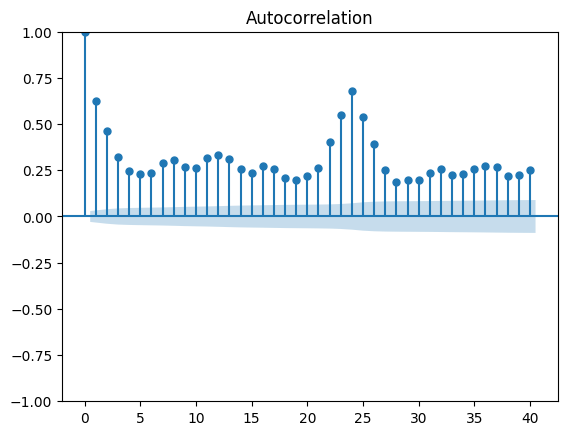

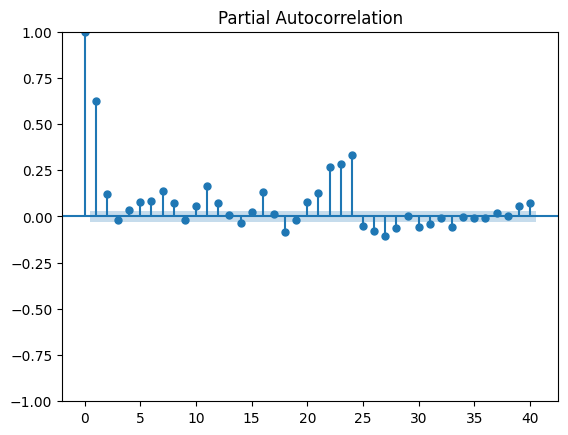

In [14]:
#plot ACF and PACF graphs
plot_acf(df, lags=40)
plt.show()

plot_pacf(df, lags=40)
plt.show()

### Train AR Model

In [15]:
#select best p value
aic_vals = {}
for p in range(1, 21):
    model1 = AutoReg(df['num_orders'], lags=p).fit()
    aic_vals[p] = model1.aic

best_p = min(aic_vals, key=aic_vals.get)
print(f"Best p (lowest AIC): {best_p}")

Best p (lowest AIC): 20


In [16]:
#fit model
model_ar = AutoReg(train['num_orders'], lags=20)
model_fit = model_ar.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:             num_orders   No. Observations:                 3576
Model:                    AutoReg(20)   Log Likelihood              -17023.218
Method:               Conditional MLE   S.D. of innovations             29.027
Date:                Sun, 25 May 2025   AIC                          34090.436
Time:                        01:33:22   BIC                          34226.317
Sample:                    03-01-2018   HQIC                         34138.891
                         - 07-27-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             19.8292      2.165      9.160      0.000      15.586      24.072
num_orders.L1      0.4632      0.017     27.660      0.000       0.430       0.496
num_orders.L2      0.1625      0.018

In [27]:
#look at model on validation set
#forecast from the end of train data up to the length of test data
start = len(train)
end = start + len(val) - 1

forecast_ar1 = model_fit.predict(start=start, end=end, dynamic=False)

#calculate RMSE
rmse_ar1 = np.sqrt(mean_squared_error(val['num_orders'], forecast_ar1))
print(f'The RMSE for the AR model is: {rmse_ar1:.2f}')

The RMSE for the AR model is: 57.43


The RMSE value for the AR Model is still too high to meet project standards. Another model should be investigated to see if one is more optimal for the given time series.

### Train SARIMA Model

Since the data is stationary, d=0

The ACF graph shows a general decrease over time, suggesting a higher q value is better.

The drop off on the PACF after the first few lags suggests volatiles data and a lower p value is better.

However, this data does not follow one particular pattern very strongly, (i.e decaying over time or sinusoidal) making its interpretation ambiguous. It would be more effective to use AIC methods to select p, d, and q.

In [18]:
#AIC for SARIMA
auto_model = auto_arima(
    train['num_orders'],
    seasonal=True,
    m=24,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None, D=None,
    max_order=10,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)
print(auto_model.summary())

In [19]:
#fit model
model_sarima = SARIMAX(df['num_orders'], order=(0, 1, 2), seasonal_order=(0,0,0, 24))
result = model_sarima.fit()

#view the summary
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00699D+00    |proj g|=  8.19975D-02

At iterate    5    f=  4.96300D+00    |proj g|=  1.49250D-02


 This problem is unconstrained.



At iterate   10    f=  4.95304D+00    |proj g|=  5.28969D-04

At iterate   15    f=  4.95299D+00    |proj g|=  1.13818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   6.426D-07   4.953D+00
  F =   4.9529868218448900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 4416
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -21872.390
Date:                Sun, 25 May 2025   AIC                   

In [20]:
#look at validation set
#predict number of forecast steps
n_test = len(val)
forecast2 = result.forecast(steps=n_test)

#calculate RMSE
rmse2 = np.sqrt(mean_squared_error(val['num_orders'], forecast2))
print(f'The RMSE for the SARIMA model is: {rmse2:.2f}')

The RMSE for the SARIMA model is: 65.28


### Train ETS Model

In [44]:
#train ETS model
model_ets = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=24
)

fit_ets = model_ets.fit()
forecast_ets = fit_ets.forecast(steps=len(val))
print(fit_ets.summary())

#calculate RMSE
rmse_ets = np.sqrt(mean_squared_error(val['num_orders'], forecast_ets))
print(f'The RMSE for the ETS model is: {rmse_ets:.2f}')

                       ExponentialSmoothing Model Results                       
Dep. Variable:               num_orders   No. Observations:                 3576
Model:             ExponentialSmoothing   SSE                        1579303.920
Optimized:                         True   AIC                          21835.609
Trend:                         Additive   BIC                          22008.705
Seasonal:                      Additive   AICC                         21836.133
Seasonal Periods:                    24   Date:                 Sun, 25 May 2025
Box-Cox:                          False   Time:                         02:21:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1442876                alpha                 True
smoothing_trend          

The RMSE is below 48 and thus meets project standards. This should be used on the test data to make sure this is still true.

#### Train ETS Model on Data when Trend Changes

In order to compensate for the change in trend, the best performing model will also be trained on the data when the trend changes. As ETS has performed the best, this will be used to see if the test data is better predicted this way.

In [36]:
#try training the model on when the data starts to trend upwards to capture the upwards trend seen in the summer months
#get the index label of the row 442 from the end (the test set is the last 442 values)
index_442_from_end = df.index[-442]
print("Index label 442 rows from the end:", index_442_from_end)

#select data from June 1st onward for training: about when the trend starts upward
train_recent = df.loc['2018-06-01':'2018-08-13 13:00:00', 'num_orders']

#make test set
test2 = df.loc['2018-08-13 14:00:00':, 'num_orders']

#train second ETS model
model_ets2 = ExponentialSmoothing(
    train_recent,
    trend='add',
    seasonal='add',
    seasonal_periods=24
)

Index label 442 rows from the end: 2018-08-13 14:00:00


## Testing: ETS Model

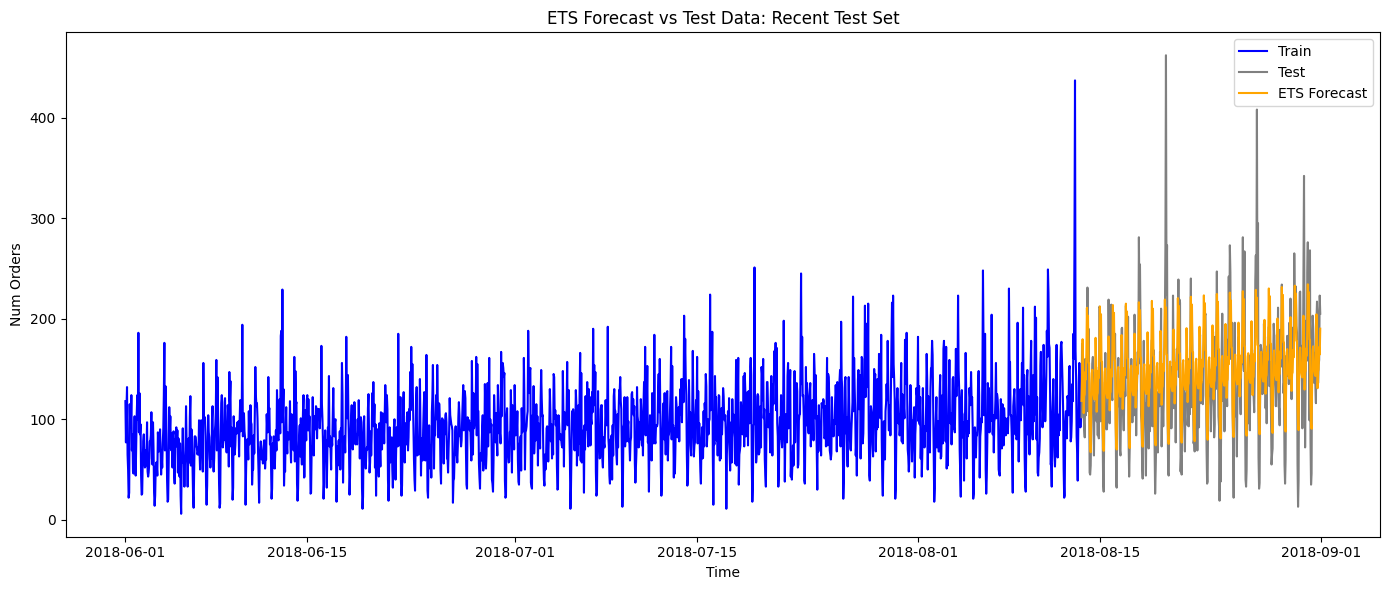

The RMSE for the ETS model is: 40.97


In [43]:
#predict test data
fit_ets2 = model_ets2.fit()
forecast_ets2 = fit_ets2.forecast(steps=len(test2))

#plot the training, test, and forecast
plt.figure(figsize=(14, 6))
plt.plot(train_recent.index, train_recent, label='Train', color='blue')
plt.plot(test2.index, test2, label='Test', color='gray')
plt.plot(test2.index, forecast_ets2, label='ETS Forecast', color='orange')
plt.title('ETS Forecast vs Test Data: Recent Test Set')
plt.xlabel('Time')
plt.ylabel('Num Orders')
plt.legend()
plt.tight_layout()
plt.show()

#calculate RMSE
rmse_ets2 = np.sqrt(mean_squared_error(test2, forecast_ets2))
print(f'The RMSE for the ETS model is: {rmse_ets2:.2f}')

## Conclusion

The goal of this project was to build a model to predict the number of taxis ordered by the hour with an RMSE value on the test data of less than 48. 

The AR model predicted the data with the a moderate RMSE. This suggests moderate autocorrelation in the data.

The SARIMA model also predicted the model with the highest RMSE based on seasonality. This model performed poorly, most likely because this model cannot adapt to changes in trends and seasonality without being retrained.

The ETS performed the best with the lowest RMSE score. However the most accurate of these models was trained on the data when the trend shifted. this allowed for the model to make more accurate predictions. 

Overall, it seems the ETS model performed best in this circumstance and can be used to predict future taxis ordered per hour.